In [10]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional,Conv1D,MaxPool1D,MaxPooling1D,GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
import re
nltk.download('punkt')

!pip install prettytable
from prettytable import PrettyTable


import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BRAVO15\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BRAVO15\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


^C


In [14]:
#Converting Dataset to Dataframe :
articles = []
labels = []

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


In [3]:
raw_df=pd.DataFrame({"Text":articles,"Labels":labels})
raw_df

,Text,Labels
0,tv future hands viewers home theatre systems ...,tech
1,worldcom boss left books alone former worldc...,business
2,tigers wary farrell gamble leicester say rus...,sport
3,yeading face newcastle fa cup premiership side...,sport
4,ocean twelve raids box office ocean twelve cr...,entertainment
...,...,...
2220,cars pull us retail figures us retail sales fe...,business
2221,kilroy unveils immigration policy ex-chatshow ...,politics
2222,rem announce new glasgow concert us band rem a...,entertainment
2223,how political squabbles snowball become common...,politics


In [4]:
#Inspecting our Dataframe :
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2225 non-null   object
 1   Labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
#Getting Number of Unique Classes in our dataset :
raw_df.Labels.unique(),print("\n Total number of Unique Target Classes : ",raw_df.Labels.nunique())


 Total number of Unique Target Classes :  5


(array(['tech', 'business', 'sport', 'entertainment', 'politics'],
       dtype=object),
 None)

In [6]:
# Text cleanup :
stemmer = PorterStemmer()

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    # lowercase text
    text = text.lower() 

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    
    # Remove the XXXX values
    text = text.replace('x', '') 
    
    # Remove white space
    text = REMOVE_NUM.sub('', text)

    #  delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub('', text) 

    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    
    # removes any words composed of less than 2 or more than 21 letters
    text = ' '.join(word for word in text.split() if (len(word) >= 2 and len(word) <= 21))

    # Stemming the words
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return text

In [7]:
dataset=raw_df

In [8]:
dataset['Text']=dataset['Text'].apply(clean_text)
dataset['Text']

0       tv futur hand viewer home theatr system plasma...
1       worldcom boss left book alon former worldcom b...
2       tiger wari farrel gambl leicest say rush make ...
3       yead face newcastl fa cup premiership side new...
4       ocean twelv raid bo offic ocean twelv crime ca...
                              ...                        
2220    car pull us retail figur us retail sale fell j...
2221    kilroy unveil immigr polici echatshow host rob...
2222    rem announc new glasgow concert us band rem an...
2223    polit squabbl snowbal becom commonplac argu bl...
2224    souness delight euro progress boss graem soune...
Name: Text, Length: 2225, dtype: object

In [9]:
#Splitting raw data for Training and Testing :
text = dataset["Text"].values
labels = dataset['Labels'].values

X_train, y_train, X_test, y_test = train_test_split(text,labels, test_size = 0.20, random_state = 42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)


(1780,) (1780,)
(445,) (445,)


In [10]:
#Reshaping Labels Input :
X_test=X_test.reshape(-1,1)
y_test=y_test.reshape(-1,1)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)


(1780,) (1780, 1)
(445,) (445, 1)


In [11]:
#Let's Fix Some Common Parameters :
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [12]:
# Tokenising , Converting Text To Sequences and Padding Our Data : 

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
word_index

Found 19057 unique tokens.


{'<OOV>': 1,
 'said': 2,
 'mr': 3,
 'year': 4,
 'would': 5,
 'also': 6,
 'new': 7,
 'peopl': 8,
 'us': 9,
 'one': 10,
 'game': 11,
 'say': 12,
 'use': 13,
 'could': 14,
 'time': 15,
 'last': 16,
 'make': 17,
 'first': 18,
 'net': 19,
 'go': 20,
 'govern': 21,
 'like': 22,
 'two': 23,
 'play': 24,
 'take': 25,
 'world': 26,
 'get': 27,
 'compani': 28,
 'film': 29,
 'work': 30,
 'uk': 31,
 'show': 32,
 'firm': 33,
 'music': 34,
 'back': 35,
 'bn': 36,
 'want': 37,
 'best': 38,
 'told': 39,
 'market': 40,
 'win': 41,
 'plan': 42,
 'made': 43,
 'includ': 44,
 'month': 45,
 'report': 46,
 'servic': 47,
 'set': 48,
 'come': 49,
 'number': 50,
 'ad': 51,
 'way': 52,
 'player': 53,
 'week': 54,
 'three': 55,
 'countri': 56,
 'need': 57,
 'mani': 58,
 'parti': 59,
 'bbc': 60,
 'labour': 61,
 'look': 62,
 'epect': 63,
 'home': 64,
 'elect': 65,
 'may': 66,
 'nation': 67,
 'sale': 68,
 'good': 69,
 'help': 70,
 'day': 71,
 'well': 72,
 'call': 73,
 'minist': 74,
 'technolog': 75,
 'million': 76,


In [13]:
# Converting into Text to sequences and padding :
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_seq = tokenizer.texts_to_sequences(y_train)
validation_padded = pad_sequences(validation_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [14]:
#Just an Example to see the raw sentance , sentance in sequences, sentance in sequences with padding:
X_train[3],train_seq[3],train_padded[3]

('school tribut tv host carson peopl turn sunday pay tribut late us tv present johnni carson nebraska town grew carson host tonight show year die januari respiratori diseas emphysema live norfolk nebraska age eight join navi return regularli donat local caus old school friend among crowd school johnni carson theater carson one bestlov tv person us ask public memori lo angel live later life began showbusi career norfolk perform magic name great carsoni age donat includ norfolk high school build new perform art centr carson die presid bush led public tribut say present profound influenc american life entertain',
 [406,
  1949,
  118,
  533,
  4422,
  8,
  256,
  400,
  263,
  1949,
  671,
  9,
  118,
  414,
  2424,
  4422,
  7885,
  2002,
  1396,
  4422,
  533,
  5529,
  32,
  4,
  788,
  314,
  12214,
  1915,
  12215,
  210,
  4423,
  7885,
  480,
  688,
  534,
  7886,
  188,
  2140,
  1054,
  395,
  613,
  689,
  406,
  879,
  429,
  1103,
  406,
  2424,
  4422,
  9366,
  4422,
  10,
 

In [15]:
print('Shape of data tensor:', train_padded.shape)
print('Shape of data tensor:', validation_padded.shape)

Shape of data tensor: (1780, 200)
Shape of data tensor: (445, 200)


In [16]:
#Using One Hot Enocder to Enocde our Multi class Labels  :
encode = OneHotEncoder()

training_labels = encode.fit_transform(X_test)
validation_labels = encode.transform(y_test)

In [17]:
print(train_padded.shape)
print(validation_labels.shape)
print(validation_padded.shape)
print(training_labels.shape)
print(type(train_padded))
print(type(validation_padded))
print(type(training_labels))
print(type(validation_labels))



# The labels must be converted to arrays
# Convert the labels to arrays
training_labels = training_labels.toarray()
validation_labels = validation_labels.toarray()

print(type(training_labels))
print(type(validation_labels))


(1780, 200)
(445, 5)
(445, 200)
(1780, 5)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [18]:
def plot_graphs(history):
  plt.title('Loss VS Accuracy')
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='test loss')
  plt.legend()
  
  plt.plot(history.history['accuracy'], label='train accuracy')
  plt.plot(history.history['val_accuracy'], label='test accuracy')
  plt.legend()
  plt.show();
  return None
def loss_graph(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show();

  return None

def acc_graph(history):
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.legend()
  plt.show();

  return None


def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

def model_eval(model,a,b,c,d):
  score=model.evaluate(a,b,verbose=0)
  score1=model.evaluate(c,d,verbose=0)
  print("\n")
  print("Model Loss on training data ",score[0])
  print("Model Accuracy on training data: ",score[1])
  print("Model Loss on validation data",score1[0])
  print("Model Accuracy on validation data: ",score1[1])
  print("\n")
  return score,score1

def model_eval(model,a,b,c,d):
  score=model.evaluate(a,b,verbose=0)
  score1=model.evaluate(c,d,verbose=0)
  print("\n")
  print("Model Loss on training data ",score[0])
  print("Model Accuracy on training data: ",score[1])
  print("Model Loss on validation data",score1[0])
  print("Model Accuracy on validation data: ",score1[1])
  print("\n")
  return score,score1



  

In [19]:
#Let's Fix Some Common Parameters :
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               164864    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,578,469
Trainable params: 6,578,469
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 18s 132ms/step - loss: 1.6050 - accuracy: 0.2258 - val_loss

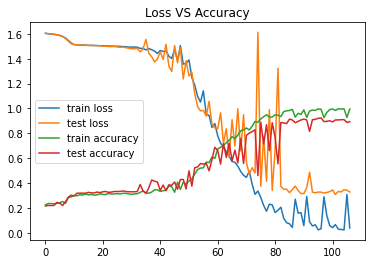

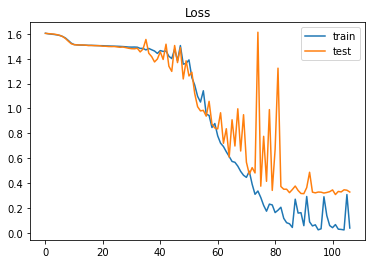

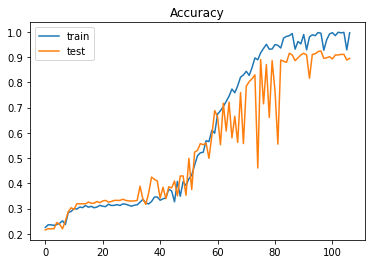

(None, None, None)

In [29]:
#With SGD
tf.keras.backend.clear_session()
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(5, activation='softmax'))

model.summary()
optim=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.5, nesterov=True, name="SGD"
)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms_n_cnn.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t23 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t23)
hist23=history

plot_graphs(hist23),loss_graph(hist23),acc_graph(hist23)

In [30]:
# Now we make predictions using the test data to see how the model performs

predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 89.44%
Precision: 0.89
Recall: 0.89
F1 score: 0.89


{'accuracy': 0.89, 'precision': 0.89, 'recall': 0.89, 'f1': 0.89}

In [32]:
model.save("model_english.h5")

In [33]:
f = open('test.txt', 'r')

In [34]:
# Testing Random Text and Predicted Classes :
f = open('test.txt', 'r')
original_text=raw_df['Text']
text = f.read()
new_text = [clean_text(text)]
print(new_text)
seq = tokenizer.texts_to_sequences(new_text)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(padded)
acc = np.argmax(padded,axis=1)
predicted_label = encode.inverse_transform(pred)
print('')
print(f'Product category id: {np.argmax(pred[0])}')
print(f'Predicted label is: {predicted_label[0]}')
print(f'Accuracy score: { acc.max() * 100}')

['appl much promot digit driver licenc featur come cost tapay accord reportsannounc septemb allow resid eight us state store state id driver licenc insid appl wallet app iphoneappl sole control sever aspect rollout cnbc reportsbut arizona connecticut georgia iowa kentucki maryland oklahoma utah bear burden maintain featur tapay epenseu state accept driver licenc iphonesappl origin comput fetch use publicrecord request mean cnbc acquir detail agreement state appleappl retain control featur launch devic compat state agenc respons maintain relev comput system legal complianc appl stipul report performancest bodi must employ alloc peopl resourc support project timelin determin appl appl request design project manag answer appl questionsth contract requir state market new featur appl review approv power market materialsth digit id must proactiv offer everi new licenc holder renew etra cost person applyingst must promot agenc local law enforc anyon els regularli check idsth end result state 

In [ ]:
from tensorflow import keras
model = keras.models.load_model('model_english.h5')

In [ ]:
f = open('entertaiment.txt', 'r')

In [ ]:
import glob

for file in glob.glob('./News/*.txt'):
    f = open(file, 'r', encoding ='utf8')


In [35]:
# Testing Random Text and Predicted Classes :
import glob
for file in glob.glob('./News/*.txt'):
    f = open(file, 'r', encoding ='utf8')
    original_text=raw_df['Text']
    text = f.read()
    new_text = [clean_text(text)]
    seq = tokenizer.texts_to_sequences(new_text)
    padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    pred = model.predict(padded)
    acc = np.argmax(padded,axis=1)
    predicted_label = encode.inverse_transform(pred)
    #print(f'Product category id: {np.argmax(pred[0])}')
    a = (f'Text {file} predicted label is: {predicted_label[0]}\n')
    result = open('result16.txt', 'a')
    result.write(a)
   
    #print(f'Accuracy score: { acc.max() * 100}')
